In [1]:
#!pip install matplotlib
#!pip install scipy
#!pip install networkx
#!pip install seaborn
#!pip install scikit-learn


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats
#import statsmodels.api as sm

# for type hinting
#from typing import List

# for pearson corr coef and p values
from scipy.stats import pearsonr

# For plotting relationships
import networkx as nx


#from matplotlib.lines import Line2D
#from matplotlib.text import Annotation
import seaborn as sns

# for non linear coefficients
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform, pdist
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# get component class from custom module
from component_module import Component, plot_correlation_network, plot_component_comparison, getKDEDensity, getDistributionBins, kde_mutual_information, drop_static_columns, performFourierAndLimitHarmonics, scaler_sec_midnight, save_component, load_component, calculate_phase_and_time_difference

In [3]:
# Load data from CSV
#df = pd.read_excel('D:\GitHub\MSc-Project-March\SWaT_DataSWaT_2015_12_22_10sec.xlsx', engine="openpyxl")
#df = pd.read_excel('/home/loz/MSc/MSc_Project/SWaT DataSWaT 2015-12-23.xlsx', engine="openpyxl")
#df = pd.read_csv("/home/loz/MSc/MSc_Project/SWaT DataSWaT 2015-12-23.csv")

In [4]:
#df_orig.index.name = 'time_in_seconds'

In [20]:
#df_orig = df_orig.drop(columns='Normal/Attack')
#df_orig.to_csv("/home/loz/MSc/MSc_Project/SWaT DataSWaT 2015-12-23.csv")

See range of values in each column so allow filtering of unchanging values before correlation matrix.

In [22]:

csv_path = "/home/loz/MSc/MSc_Project/SWaT DataSWaT 2015-12-23.csv"
converted_path = "/home/loz/MSc/MSc_Project/SWaT_12_23_sec_orig.csv"
df_orig = pd.read_csv(csv_path, index_col='time_in_seconds')

df_orig.columns
# drop time columns and use normal index as 1 second increments anyway
#df_orig = df_orig.drop(columns=['Timestamp', 'time', 'date'])
# call function to normalise and covert timestamp to seconds since midnight
#df_norm_sec = scaler_sec_midnight(csv_path, converted_path, scaler_type='minmax')  
df_norm_sec = pd.read_csv(converted_path, index_col='time_in_seconds')

df= df_norm_sec.copy()

In [23]:
#help(Styler)

In [24]:
# Display correlation matrix and p-values
#print("Correlation Matrix:")
#display(correlation_matrix_styled)
#print("\nP-values:")
#display(p_values_styled)

# Create Component Object for Each Component in SWaT Data

Use a class to hold knowledge about each component which can be updated throughout pipeline. Can include functions which return top antecendent/ dependent modules etc.

In [25]:
#df_norm_sec

# check index is timestamp otherwise it's extracted as a component
if df.index.name != 'time':
    df = df.set_index('time')
    
type(time[0])

In [26]:
df_orig.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'],
      dtype='object')

In [27]:
calculate_phase_and_time_difference(df_orig,'LIT101', 'FIT101')

(2.5263780217198546, 1737.009577189895)

In [33]:
for col_1 in df_orig.columns:
    phase_dict[col_1] = [] 
    for col_2 in df_orig.columns:
        try:
            phase, time_diff = calculate_phase_and_time_difference(df_orig, col_1, col_2)
            phase_dict[col_1].append({'component': col_2, 'phase': phase, 'time_diff': time_diff})
        except Exception as e:
            phase_dict[col_1].append({'component': col_2, 'phase': 9999, 'time_diff': 9999})


/home/loz/MSc/MSc_Project/final_code/component_module.py:802: RuntimeWarning: divide by zero encountered in scalar divide
  time_difference = phase_difference / (2 * np.pi * avg_freq)


In [34]:
phase_dict.keys()

dict_keys(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'])

In [36]:
phase_dict['LIT101']

[{'component': 'FIT101',
  'phase': 2.5263780217198546,
  'time_diff': 1737.009577189895},
 {'component': 'LIT101', 'phase': 0.0, 'time_diff': 0.0},
 {'component': 'MV101',
  'phase': 2.538419032369298,
  'time_diff': 1745.2883662853174},
 {'component': 'P101',
  'phase': 3.4273879908226283,
  'time_diff': 2356.4983995355146},
 {'component': 'P102', 'phase': 9999, 'time_diff': 9999},
 {'component': 'AIT201',
  'phase': -1.049789438411084,
  'time_diff': -962.3760671738239},
 {'component': 'AIT202',
  'phase': -1.8041079100036126,
  'time_diff': -708.8075590585698},
 {'component': 'AIT203',
  'phase': -1.1460466357619095,
  'time_diff': -1370.3715204380692},
 {'component': 'FIT201',
  'phase': 3.418961823165965,
  'time_diff': 2350.7049934051574},
 {'component': 'MV201',
  'phase': 3.42608422829807,
  'time_diff': 2355.6019984537807},
 {'component': 'P201', 'phase': 9999, 'time_diff': 9999},
 {'component': 'P202', 'phase': 9999, 'time_diff': 9999},
 {'component': 'P203',
  'phase': 3.41

In [37]:
sorted_phase_LIT101 = sorted(phase_dict['LIT101'], key=lambda x: x['time_diff'])

print(sorted_phase_LIT101)

[{'component': 'MV302', 'phase': 3.0784821702536207, 'time_diff': -4031.6351008412935}, {'component': 'P602', 'phase': -2.608830535392224, 'time_diff': -1793.6997497139528}, {'component': 'FIT301', 'phase': -2.4813617108210613, 'time_diff': -1706.0586417048994}, {'component': 'PIT502', 'phase': -1.2526555246729587, 'time_diff': -1497.847820817523}, {'component': 'AIT203', 'phase': -1.1460466357619095, 'time_diff': -1370.3715204380692}, {'component': 'AIT501', 'phase': -1.1981514606161852, 'time_diff': -1318.0612206862559}, {'component': 'AIT504', 'phase': -0.9051393936441574, 'time_diff': -1131.5054645856146}, {'component': 'FIT502', 'phase': -0.9625901744355627, 'time_diff': -1058.9252044016537}, {'component': 'DPIT301', 'phase': -2.158923040416133, 'time_diff': -973.354847287051}, {'component': 'AIT201', 'phase': -1.049789438411084, 'time_diff': -962.3760671738239}, {'component': 'P302', 'phase': -2.0964077833016534, 'time_diff': -945.1697163663833}, {'component': 'AIT202', 'phase': 

In [38]:
df_lit_phase = pd.DataFrame(sorted_phase_LIT101)

In [42]:
df_lit_phase.iloc[10:30,]

,component,phase,time_diff
10,P302,-2.096408,-945.169716
11,AIT202,-1.804108,-708.807559
12,MV304,-2.536478,-147.480247
13,MV301,-0.326525,-6.150736
14,LIT101,0.000000,0.000000
15,P301,2.561771,6.242579
16,LIT301,1.473822,1013.325194
17,LIT401,2.212681,1521.327437
18,FIT101,2.526378,1737.009577
19,MV101,2.538419,1745.288366


In [19]:
components['FIT101'].max_value

0.9778320726591312

In [23]:
components['MV101'].min_value

0.0

In [21]:
components['FIT101'].step_size

0.23871185373750686

In [22]:
components['MV101'].step_size

1.0

In [43]:
def switch_ratio(component):
    ''' 
    Get rate of change in value to distinguish swichs etc. from sensors
    this computes how many seconds/ cycles it takes from min to max at the maximum step size.
    
    '''
    value_range = component.max_value - component.min_value
    change_ratio =  value_range/ component.step_size
    
    return change_ratio

In [57]:
switch_ration_dict = {}
for component in components.keys():
    #print(components[component].name)
    switch_ration_dict[components[component].name] = switch_ratio(components[component])

/tmp/ipykernel_44343/3753555764.py:4: RuntimeWarning: invalid value encountered in scalar divide
  change_ratio =  value_range/ component.step_size


In [58]:
switch_ration_dict.items()

dict_items([('FIT101', 4.096286201750075), ('LIT101', 150.18229379918944), ('MV101', 1.0), ('P101', 1.0), ('P102', nan), ('AIT201', 7.563975354084886), ('AIT202', 14.362666723666546), ('AIT203', 84.71600040009484), ('FIT201', 3.905454256619541), ('MV201', 1.0), ('P201', nan), ('P202', nan), ('P203', 1.0), ('P204', nan), ('P205', 1.0), ('P206', nan), ('DPIT301', 5.422356457098385), ('FIT301', 3.893611372880248), ('LIT301', 139.04122267551796), ('MV301', 1.0), ('MV302', 1.0), ('MV303', 1.0), ('MV304', 1.0), ('P301', 1.0), ('P302', 1.0), ('AIT401', 3.1936694073782257), ('AIT402', 28.940110142267063), ('FIT401', 6.790799739922041), ('LIT401', 144.8947735633656), ('P401', nan), ('P402', nan), ('P403', nan), ('P404', nan), ('UV401', nan), ('AIT501', 11.888349514563664), ('AIT502', 20.44958065145333), ('AIT503', 30.335568142411848), ('AIT504', 2.6841867531720967), ('FIT501', 8.599765944996877), ('FIT502', 3.90833877639886), ('FIT503', 3.799968757322461), ('FIT504', 2.7674266627940773), ('P501

In [63]:
sorted_switch_ration_dict = sorted(switch_ration_dict.items(), key=lambda item: item[1])

In [64]:
sorted_switch_ration_dict

[('MV101', 1.0),
 ('P101', 1.0),
 ('MV201', 1.0),
 ('P203', 1.0),
 ('P205', 1.0),
 ('MV301', 1.0),
 ('MV302', 1.0),
 ('MV303', 1.0),
 ('MV304', 1.0),
 ('P301', 1.0),
 ('P302', 1.0),
 ('P602', 1.0),
 ('AIT504', 2.6841867531720967),
 ('FIT504', 2.7674266627940773),
 ('AIT401', 3.1936694073782257),
 ('PIT502', 3.3500029652380467),
 ('FIT503', 3.799968757322461),
 ('FIT301', 3.893611372880248),
 ('FIT201', 3.905454256619541),
 ('FIT502', 3.90833877639886),
 ('FIT101', 4.096286201750075),
 ('FIT601', 5.000734963958055),
 ('DPIT301', 5.422356457098385),
 ('FIT401', 6.790799739922041),
 ('FIT501', 8.599765944996877),
 ('AIT501', 11.888349514563664),
 ('AIT202', 14.362666723666546),
 ('PIT501', 15.966422729228759),
 ('AIT402', 28.940110142267063),
 ('LIT101', 150.18229379918944),
 ('P102', nan),
 ('AIT201', 7.563975354084886),
 ('AIT203', 84.71600040009484),
 ('P201', nan),
 ('P202', nan),
 ('P204', nan),
 ('P206', nan),
 ('PIT503', 14.821444493981366),
 ('LIT301', 139.04122267551796),
 ('LIT4

In [47]:
switch_ratio(components['MV101'])

1.0

In [48]:
switch_ratio(components['LIT101'])

150.18229379918944

In [50]:
switch_ratio(components['FIT101'])

4.096286201750075

In [45]:


# iterate through every column and create object of component class
# dictionary for all component objects
# intialise from original data- not normalised
components = {}
for n, component in enumerate(df_orig.columns):
    # print(n, component)
    components[component] = Component(name= component, list_position= n, df_orig=df_orig)


In [46]:

df_orig

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
time_in_seconds,,,,,,,,,,,,,,,,,,,,,
0,0.0,813.3956,1,2,1,262.3045,8.402845,440.0667,1.913562,2,...,0.308811,2,1,254.0855,1.025214,193.2197,0.000000,1,1,1
1,0.0,813.0424,1,2,1,262.3045,8.402845,440.2974,2.148848,2,...,0.310348,2,1,254.0214,1.025214,193.2197,0.000000,1,1,1
2,0.0,813.0424,1,2,1,262.3045,8.402845,440.8357,2.280844,2,...,0.310348,2,1,253.8612,1.025214,193.2037,0.000000,1,1,1
3,0.0,813.0031,1,2,1,261.9841,8.400923,441.4509,2.368629,2,...,0.310348,2,1,253.8612,1.025214,193.0595,0.000000,1,1,1
4,0.0,812.7283,1,2,1,261.9841,8.400923,442.3225,2.424375,2,...,0.310348,2,1,254.0695,1.025214,193.0595,0.000000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.0,811.2368,1,1,1,253.8452,8.412458,325.8652,0.000000,1,...,0.308619,2,1,254.5181,1.057252,193.4119,0.000064,1,1,1
86396,0.0,811.1975,1,1,1,253.8452,8.412458,325.8652,0.000000,1,...,0.308619,2,1,254.3098,1.057252,193.4119,0.000064,1,1,1
86397,0.0,811.0797,1,1,1,253.8452,8.412458,325.8139,0.000000,1,...,0.308619,2,1,254.3098,1.057252,193.1716,0.000064,1,1,1


In [ ]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    correlation_dict = {col: value for col, value in zip(correlation_matrix.columns, correlation_matrix.loc[component_name]) if col != component_name }
    component_obj.correlation_dict = correlation_dict
    #print(component_name, component_obj.correlation_dict )

    # Convert p-value row to dictionary with row index and value
    p_value_dict = {col: value for col, value in zip(p_values.columns, p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.p_value_dict = p_value_dict

# Make Matrices then update object for each component

### Calculate the linear (Pearson) correlation matrix

In [16]:
# set linear correaltion attribute

#if df.index.name != 'Timestamp':
#    df = df.set_index('Timestamp')


# Calculate the linear correlation matrix
correlation_matrix = df.corr().round(decimals= 4)

# DataFrame to store p-values with rows and cols being column names
p_values = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate p-values
# for every column
for col1 in df.columns:
    # calculate values with everyother column
    for col2 in df.columns:
        correlation_coefficient, p_value = pearsonr(df[col1], df[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
correlation_matrix_styled  = correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision= 2)
p_values_styled  = p_values.style.background_gradient(cmap='coolwarm').format(precision= 2)



### Assign relevant linear correllation values to each component object

In [17]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    correlation_dict = {col: value for col, value in zip(correlation_matrix.columns, correlation_matrix.loc[component_name]) if col != component_name }
    component_obj.correlation_dict = correlation_dict
    #print(component_name, component_obj.correlation_dict )

    # Convert p-value row to dictionary with row index and value
    p_value_dict = {col: value for col, value in zip(p_values.columns, p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.p_value_dict = p_value_dict

# Non-Linear Correlation of Components
The previous stage looked for linear correlation between components, other non- linear methods were evaluated as the complex interplay of componets could lead to non-linear behaviour even with pairwise linear relationships. These methods look for monatonic relationships- the values for two components consistently change together ( positive or negative).

### Calculate the correlation matrix using Spearman's rank correlation

In [18]:
# Calculate the correlation matrix using Spearman's rank correlation
non_lin_correlation_matrix = df.corr(method='spearman').round(decimals=4)

# DataFrame to store p-values with rows and cols being column names
non_lin_p_values = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate p-values
# for every column
for col1 in df.columns:
    # calculate values with every other column
    for col2 in df.columns:
        correlation_coefficient, p_value = spearmanr(df[col1], df[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        non_lin_p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
non_lin_correlation_matrix_styled = non_lin_correlation_matrix.style.background_gradient(cmap='coolwarm')
non_lin_p_values_styled = non_lin_p_values.style.background_gradient(cmap='coolwarm').format(precision=2)


In [19]:
#non_lin_correlation_dict

### Assign relevant non-linear correlation values to each component object

In [20]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    non_lin_correlation_dict = {col: value for col, value in zip(non_lin_correlation_matrix.columns, non_lin_correlation_matrix.loc[component_name]) if col != component_name}
    component_obj.non_lin_correlation_dict = non_lin_correlation_dict
    #print(component_name, component_obj.non_lin_correlation_dict )

    # Convert p-value row to dictionary with row index and value
    non_lin_p_value_dict = {col: value for col, value in zip(non_lin_p_values.columns, non_lin_p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.non_lin_p_value_dict = non_lin_p_value_dict

In [21]:
#index_values = correlation_matrix.index.values
#print(index_values)

In [22]:
#specific_component = components['LIT101']
#specific_component.correlation_list
#specific_component.correlation_dict

In [23]:
#non_lin_correlation_matrix

In [24]:

#non_lin_correlation_matrix.to_csv(r'D:\GitHub\MSc-Project-March\non_lin_cor_matrix.csv', index=True)

In [25]:
#specific_component.get_correlated_components_p_value()

# Visualising Relationships

In [27]:
components['LIT101'].get_strongest_correlated_components('linear', top_n_corrs =6)

{'AIT202': 0.1846,
 'FIT504': 0.179,
 'AIT501': 0.1182,
 'FIT503': 0.0626,
 'PIT502': 0.04,
 'AIT201': 0.0379}

In [28]:
strongest_correlations = components['LIT401'].get_strongest_correlated_components('linear', top_n_corrs =10)

In [29]:
strongest_correlations

{'FIT101': 0.6838,
 'MV101': 0.6809,
 'FIT201': 0.4077,
 'P203': 0.4042,
 'P101': 0.3977,
 'MV201': 0.3887,
 'LIT301': 0.3521,
 'AIT502': 0.2804,
 'P205': 0.2422,
 'FIT401': 0.2045}

## Compare Linear & Non-Linear Correlations

<class 'int'>


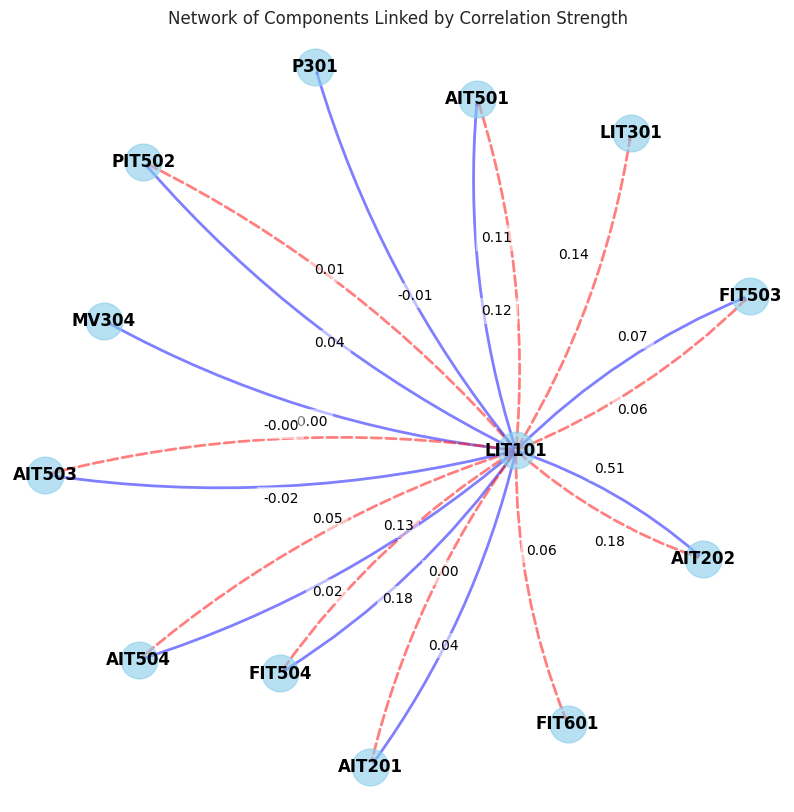

In [35]:
plot_correlation_network(components['LIT101'], top_n_corrs= 10)

## Compare Two Components Linear & Non-Linear Correlations

In [31]:
linear_corr_dict_1 = components['LIT301'].get_strongest_correlated_components('linear', top_n_corrs =4)
non_linear_corr_dict_1 = components['LIT301'].get_strongest_correlated_components('non_linear', top_n_corrs =4)
linear_corr_dict_2 = components['LIT401'].get_strongest_correlated_components('linear', top_n_corrs =4)
non_linear_corr_dict_2 = components['LIT401'].get_strongest_correlated_components('non_linear', top_n_corrs =4)

# Create two components
component1 = components['LIT301']
component2 = components['LIT401']

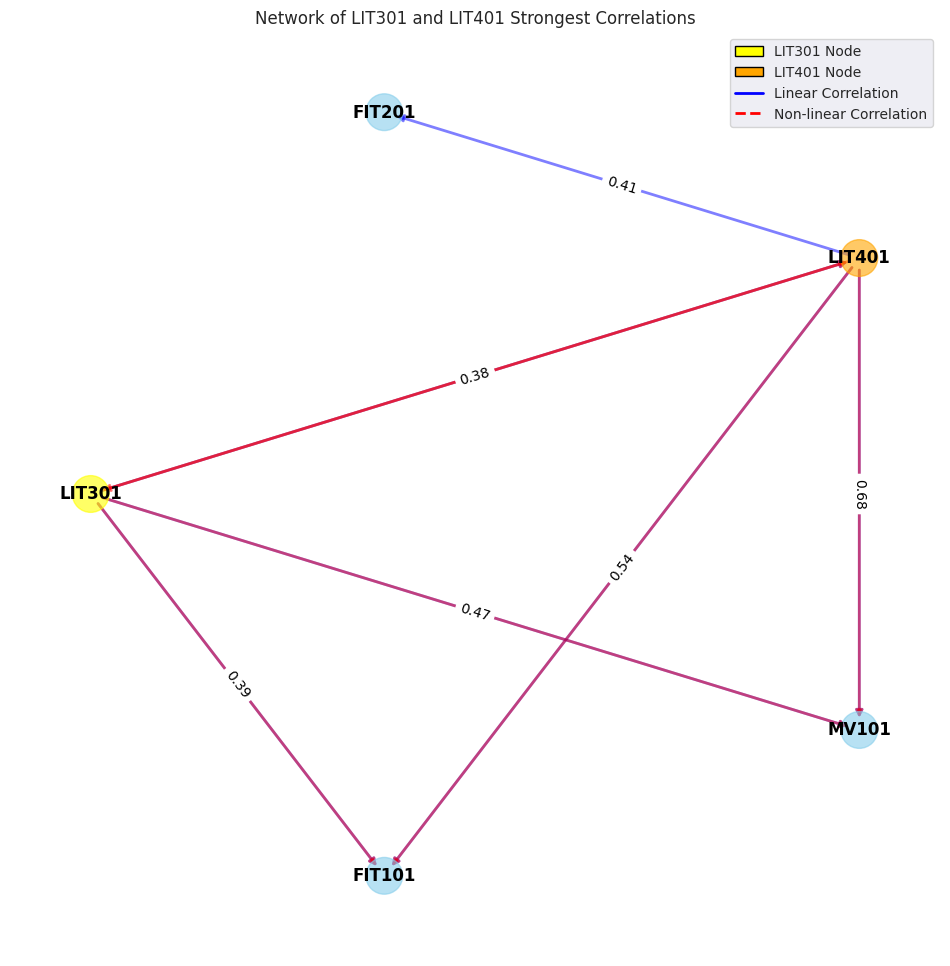

In [32]:
# Plot comparison network for both components
plot_component_comparison(component1 ,component2, linear_corr_dict_1, non_linear_corr_dict_1, linear_corr_dict_2, non_linear_corr_dict_2, top_n_corrs=3, layout= nx.shell_layout)

## Observations
P value ( statistical significance) value of 5% indicates 38 of 39 components disprove the null hypothesis that the relationship between components is random. This numebr of related components is acheived by using a Pearson correlation coefficient 0f 0.01 or above ( a very week linear correlation).
These Values were calculated from the correlation from the LIT101 water level sensor which is the main water tank at the beginning of the process ( and so is understandably linked to all other components to some degree.
Restricted the results to correlation coefficients above 0.6 identifies 5 componnets with strong correlations, all of which are in the same or following stage and are related to the movement of water ( pumps or flow sensors). This suggests the Pearson values are more useful is revelaing system dependencies.


# Kernel Distributions

Get distributions for each variable. Get range, divide into 100 bins then count variables ineach. Visualise in plot

Sample df as 10 second mean for all values so df is 10% of original to east manipulation

In [40]:
#df['LIT101']

Var Range:  0.47366934086041035


/home/loz/MSc/MSc_Project/final_code/component_module.py:389: RuntimeWarning: divide by zero encountered in scalar divide
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

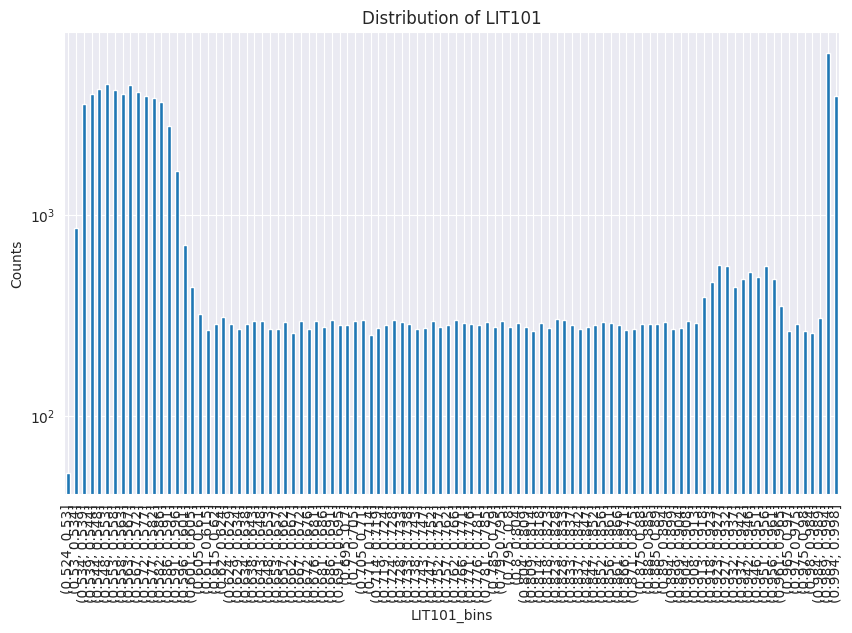

In [41]:
# test with FIT101
#lit101_dist, bins = getDistribution('LIT101')
#plotBinCounts(lit101_dist, bins)

getDistributionBins(df, 'LIT101')

In [ ]:
getKDEDensity(df, 'LIT101', save_path='D:\GitHub\MSc-Project-March\Write_Up\Charts\lit_101_kde_plot.jpeg')

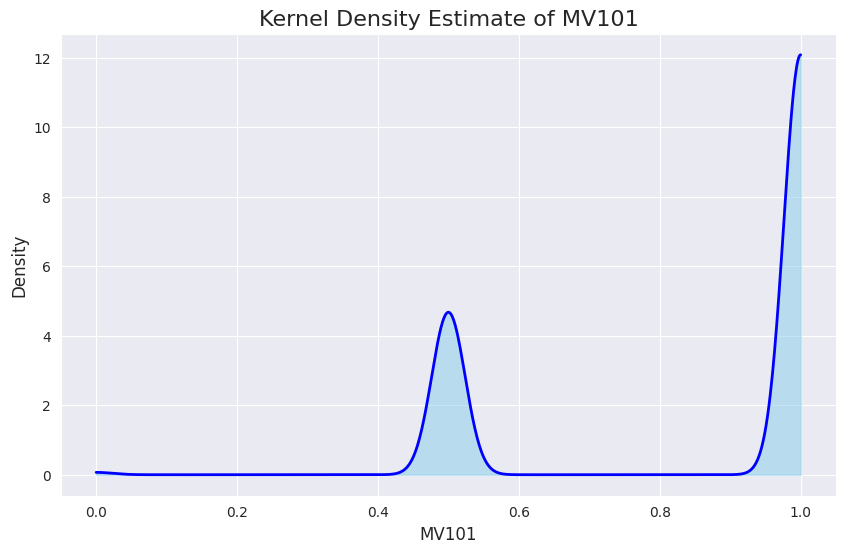

In [42]:
getKDEDensity(df, 'MV101')

# Calculate mutual information between features
mutual_info_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate mutual information
for col1 in df.columns:
    for col2 in df.columns:
        mutual_info = mutual_info_regression(df[[col1]], df[col2])[0]
        mutual_info_matrix.loc[col1, col2] = mutual_info

# Display the mutual information matrix
print(mutual_info_matrix)


# using scaled already
scaler = StandardScaler()
df_normalised = scaler.fit_transform(df)
# convert back to df
df_normalised = pd.DataFrame(df_normalised, columns=df.columns)

In [43]:
#mi_lit101 = kde_mutual_information(df_normalised, 'LIT101', num_points=100, n_jobs=-1)
#print(mi_lit101)

# slow so son't re-run. Import df instead

mi_results_df = pd.DataFrame()
for component_name, component_obj in components.items():

    try:
        mi_results = kde_mutual_information(df_normalised, component_name, num_points=100, n_jobs=-1)
        mi_results_df[component_name] = mi_results
    except Exception as e:
        # In case of error, add a column of NaNs
        mi_results_df[component_name] = np.nan
        print(f"Error calculating MI for {component_name}: {e}")

    print(f"Finished:{component_name}")

# Transpose the result to make each row represent a component and each column an MI score
mi_results_df = mi_results_df.T

# Fill any missing values (optional, this step is already handled)
mi_results_df.fillna(np.nan, inplace=True)

# Print the final DataFrame
print(mi_results_df)

In [44]:
mi_results_df.to_csv('D:\GitHub\MSc-Project-March\SWaT Data\mi_results.csv', index=False)

NameError: name 'mi_results_df' is not defined

In [45]:
#mi_results_df = pd.read_csv('D:\GitHub\MSc-Project-March\SWaT Data\mi_results.csv')
mi_results_df = pd.read_csv('/home/loz/MSc/MSc_Project/SWaT Data/mi_results.csv')

In [46]:
mi_results_df.rename(columns={'Unnamed: 0':'Component'}, inplace=True)
mi_results_df.set_index('Component', inplace=True)
mi_results_df.index

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'AIT201', 'AIT202', 'AIT203',
       'FIT201', 'MV201', 'P203', 'P205', 'DPIT301', 'FIT301', 'LIT301',
       'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402',
       'FIT401', 'LIT401', 'P402', 'UV401', 'AIT501', 'AIT502', 'AIT503',
       'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P602'],
      dtype='object', name='Component')

In [47]:
#mi_results_df

In [48]:
components

{'FIT101': <component_module.Component at 0x78bdd2576890>,
 'LIT101': <component_module.Component at 0x78bdd2577340>,
 'MV101': <component_module.Component at 0x78bdd2576b90>,
 'P101': <component_module.Component at 0x78bdd25771f0>,
 'AIT201': <component_module.Component at 0x78bdd25752d0>,
 'AIT202': <component_module.Component at 0x78bdd2577970>,
 'AIT203': <component_module.Component at 0x78bdd25766b0>,
 'FIT201': <component_module.Component at 0x78bdd2576bf0>,
 'MV201': <component_module.Component at 0x78bdd2577190>,
 'P203': <component_module.Component at 0x78bdd2577550>,
 'P205': <component_module.Component at 0x78bdd2576920>,
 'DPIT301': <component_module.Component at 0x78bdd25763e0>,
 'FIT301': <component_module.Component at 0x78bdd2576b00>,
 'LIT301': <component_module.Component at 0x78bdd2576da0>,
 'MV301': <component_module.Component at 0x78bdd2577be0>,
 'MV302': <component_module.Component at 0x78bdd25744c0>,
 'MV303': <component_module.Component at 0x78bdd25767d0>,
 'MV304

In [49]:
for component_name, component in components.items():
    if component_name in mi_results_df.columns:
        component.mutual_info_dict = mi_results_df[component_name]
    else:
        component.mutual_info_dict = {}


In [50]:
components.keys()

dict_keys(['FIT101', 'LIT101', 'MV101', 'P101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P203', 'P205', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P602'])

In [51]:
top_mi = components['LIT101'].get_mutual_info(top_mi_components=6)
#top_mi = top_mi[4:]
top_lin_cor = components['LIT101'].get_strongest_correlated_components(top_n_corrs=6)
top_non_lin_cor = components['LIT101'].get_strongest_correlated_components(source_data='non_linear', top_n_corrs=6)

In [52]:
top_mi = list(top_mi.keys())
top_lin_cor = list(top_non_lin_cor.keys())
top_non_lin_cor = list(top_non_lin_cor.keys())

In [53]:
#top_mi = top_mi[4:]

In [54]:
top_mi

['FIT504', 'P301', 'FIT401', 'FIT501', 'PIT501', 'P402']

In [55]:
comp_dict = {}
for name, values in zip(['Mutual Info', 'Linear Cor', 'Non Linear Cor'], [top_mi, top_lin_cor, top_non_lin_cor]):
    comp_dict[name] = values

In [56]:
data = pd.DataFrame(comp_dict)

In [57]:
data.head(10)

,Mutual Info,Linear Cor,Non Linear Cor
0,FIT504,AIT202,AIT202
1,P301,LIT301,LIT301
2,FIT401,FIT504,FIT504
3,FIT501,AIT501,AIT501
4,PIT501,FIT503,FIT503
5,P402,FIT601,FIT601


1,FIT-101,Sensor,Flow meter; Measures inflow into raw water tank.
2,LIT-101,Sensor,Level Transmitter; Raw water tank level.
3,MV-101,Actuator,Motorized valve; Controls water flow to the raw water tank.

# Create masks for Spearman and Mutual Information correlations higher than Pearson

This could identify componets such as switches which are strongly correlated but non-linear and would be missed in linear only analysis

In [58]:
# Create masks for Spearman and Mutual Information correlations higher than Pearson
spearman_higher_mask = non_lin_correlation_matrix > correlation_matrix
#mutual_info_higher_mask = mutual_info_matrix > correlation_matrix

# Extract values where Spearman correlation is higher than Pearson
spearman_higher_values = non_lin_correlation_matrix[spearman_higher_mask]

# Extract values where Mutual Information correlation is higher than Pearson
# needs to be cahnged to ranked value
#mutual_info_higher_values = mutual_info_matrix[mutual_info_higher_mask]

# Combine the extracted values
#higher_values = pd.concat([spearman_higher_values, mutual_info_higher_values])

# Plot the higher values
plt.figure(figsize=(10, 6))
sns.barplot(x=higher_values.index, y=higher_values.values, palette='coolwarm')
plt.title('Values where Spearman or Mutual Info are higher than Pearson')
plt.xlabel('Component Pair')
plt.ylabel('Correlation Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


NameError: name 'higher_values' is not defined

<Figure size 1000x600 with 0 Axes>

# Auto Correllation

In [70]:
org_series = df_norm_sec.LIT101
shift_size = 100

In [74]:


def get_cross_corr(series_1, series_2, shift=100, start=0, stop=80000):
    '''
    Get cross correlation or suto correlation if same series passed twice
    :param series_1: keeps original timing
    :param series_2: gets shifted
    :param shift: shift in seconds
    :return: dict of correlation strength with time as key
    '''
    
    auto_corrs = {}
    for x in range(start,stop, shift_size):
        shifted_series = org_series.shift(x)
        auto_corrs[x] = org_series.corr(shifted_series)
        
    return auto_corrs

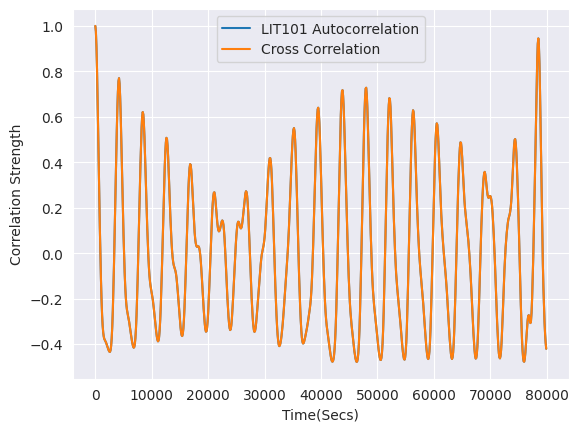

In [76]:
auto_corrs_lit101 = get_cross_corr(df_norm_sec.LIT101, df_norm_sec.LIT101, shift=1, start=0,stop=80000)
cross_lit101_fit101 = get_cross_corr(df_norm_sec.LIT101, df_norm_sec.FIT101, shift=1, start=0,stop=80000)




#plt.plot(auto_corrs.values(), label='Original Data')
plt.plot(list(auto_corrs_lit101.keys()), list(auto_corrs_lit101.values()), label='LIT101 Autocorrelation')
plt.plot(list(cross_lit101_fit101.keys()), list(cross_lit101_fit101.values()), label='Cross Correlation')

#plt.xlim(4100,20000)
plt.xlabel('Time(Secs)')
plt.ylabel('Correlation Strength')
plt.legend()
plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/lit101_autocor.jpeg')
plt.show()

In [67]:
from scipy.signal import find_peaks

In [68]:
auto_corr_values = np.array(list(auto_corrs.values()))

NameError: name 'auto_corrs' is not defined

In [69]:
fundamental_frequency

NameError: name 'fundamental_frequency' is not defined

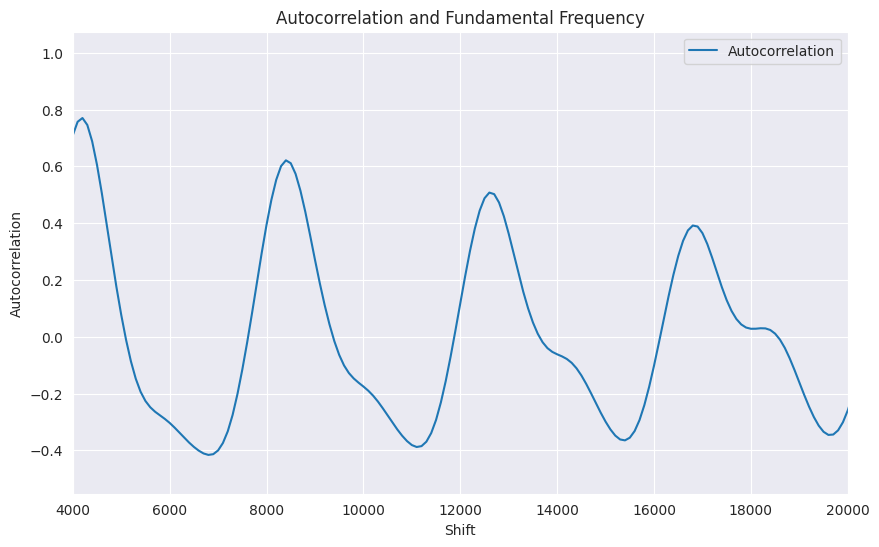

In [110]:
# Fourier Transform on the auto correlation values
fft_data = np.fft.fft(auto_corr_values)
frequencies = np.fft.fftfreq(len(auto_corr_values), d=shift_size)


# Compute the power spectrum (magnitude of the FFT)
power_spectrum = np.abs(fft_data)

# Find the fundamental frequency (the peak in the power spectrum)
fundamental_frequency_index = np.argmax(power_spectrum[1:]) + 1  # Ignore the 0 frequency component
fundamental_frequency = np.abs(frequencies[fundamental_frequency_index])

# Plot the autocorrelation values
plt.figure(figsize=(10, 6))
plt.plot(list(auto_corrs.keys()), auto_corr_values, label='Autocorrelation')


        
# Add labels, title, and legend
plt.xlim(4000, 20000)
plt.xlabel('Shift')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation')
plt.legend()

# Show the plot
plt.show()


In [87]:
type(wave)

list

In [89]:

peak_indices, _ = find_peaks(wave)

In [90]:
peak_indices

array([ 42,  84, 126, 168, 182, 211, 225, 253, 267, 310, 352, 395, 438,
       480, 521, 563, 605, 647, 690, 700, 744, 768, 785])

In [62]:
type(auto_corrs)

dict

In [63]:
auto_corrs = pd.Series(auto_corrs)

In [76]:
reconstructed_signal, fft_data_limited  = performFourierAndLimitHarmonics(series=auto_corrs)

UnboundLocalError: local variable 'data' referenced before assignment

In [77]:
reconstructed_signal.real.shape

(800,)

In [70]:
lit_non_cor = components['LIT101'].get_correlated_components(source_data='non_linear')

In [73]:
lit_non_cor['FIT101']

-0.4867

In [75]:
lit_non_cor['FIT201']

-0.3233

In [76]:
lit_lin_cor = components['LIT101'].get_correlated_components(source_data='linear')

In [77]:
lit_lin_cor['FIT101']

-0.6474

In [78]:
lit_lin_cor['FIT201']

-0.6752

In [79]:
fit101_lin_cor = components['FIT101'].get_correlated_components(source_data='linear')

In [80]:
fit101_lin_cor['LIT101']

-0.6474